In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from matplotlib.animation import FuncAnimation
from matplotlib.patches import RegularPolygon
from matplotlib.collections import PatchCollection
from math import sin, cos, atan2, sqrt, pi

In [2]:
def wrap_to_pi(theta):
    return (theta + pi) % (2 * pi) - pi

In [3]:
def create_triangle(pose, r=0.1):
    xy = pose[:2] 
    theta = pose[2] - pi / 2
    kwargs = dict(xy=xy, numVertices=3, radius=r, orientation=theta)
    return RegularPolygon(**kwargs)

In [4]:
class Robot(object):
    '''A differential drive robot living in the x, y, theta plane'''
    
    def __init__(self, init_pose=np.zeros(3)):
        self.pose = init_pose 
        self.patch = create_triangle(init_pose) 
   
    def update_pose(self, v, w, dt=0.1):
        dx = dt * v * cos(self.pose[2])
        dy = dt * v * sin(self.pose[2])
        dtheta = dt * w
        
        self.pose += np.array([dx, dy, dtheta])
        self.patch._xy += np.array([dx, dy])
        self.patch._orientation += dtheta

In [5]:
class RobotControl(object):
    k_alpha = 1
    k_beta = -0.5
    k_rho = 0.1
    
    def __init__(self, goal_pose=np.zeros(3)):
        self.goal_pose = goal_pose
    
    def control_law(self, measured_pose):
        e = self.goal_pose - measured_pose
        dx, dy = e[0], e[1]
        theta = wrap_to_pi(measured_pose[2])

        rho = sqrt(dx**2 + dy**2)
        alpha = wrap_to_pi(-theta + atan2(dy, dx))
        beta = wrap_to_pi(-theta - alpha)

        v = self.k_rho * rho
        w = self.k_alpha * alpha + self.k_beta * beta
        return v, w

In [6]:
def get_limits(init_pose, goal_pose):
    x_min = min(init_pose[0], goal_pose[0]) - 1
    x_max = max(init_pose[0], goal_pose[0]) + 1

    y_min = min(init_pose[1], goal_pose[1]) - 1
    y_max = max(init_pose[1], goal_pose[1]) + 1
    return [x_min, x_max, y_min, y_max]

In [7]:
def configure_axes(ax, init_pose, goal_pose):
    limits = get_limits(init_pose, goal_pose)
    ax.set_xlim(limits[:2])
    ax.set_ylim(limits[2:])
    
    ax.set_xlabel('$ x $')
    ax.set_ylabel('$ y $')
    ax.set_title('Trajectory')

In [8]:
class RobotPlotter:
    '''Maintains state for FuncAnimation'''
    
    def __init__(self, robot, controller, goal_pose):
        self.robot = robot
        self.controller = controller
        
        self.fig, self.ax = plt.subplots()
        self.history, = self.ax.plot([], [], linestyle='dashed')
        
        self.xdata = []
        self.ydata = []
        
        self.goal_pose = goal_pose
        self.robot_patch = robot.patch
        self.goal_patch = create_triangle(goal_pose)

    def init_ani(self):
        init_pose = self.robot.pose
        configure_axes(self.ax, init_pose, self.goal_pose)
        
        self.ax.scatter(*init_pose[:2], s=12)
        self.ax.add_patch(self.robot_patch)
        self.ax.add_patch(self.goal_patch)
    
    def step(self, frame):
        measured_pose = self.robot.pose
        self.xdata += [measured_pose[0]]
        self.ydata += [measured_pose[1]]
        v, w = self.controller.control_law(measured_pose)
        
        self.robot.update_pose(v, w)
        self.history.set_data(self.xdata, self.ydata)
    
    def animate(self, save_gif=False):
        kwargs1 = dict(fig=self.fig, func=self.step, init_func=self.init_ani)
        kwargs2 = dict(frames=400, interval=10, repeat=False, blit=True)

        ani = FuncAnimation(**kwargs1, **kwargs2)
        if save_gif: ani.save('trajectory.gif', dpi=80, writer='imagemagick')

In [9]:
def main():
    init_pose = np.array([4, 2, 0], dtype=np.float32)
    goal_pose = np.array([2, 3, 0], dtype=np.float32)

    robot = Robot(init_pose)
    controller = RobotControl(goal_pose)
    plotter = RobotPlotter(robot, controller, goal_pose)

    plotter.animate(save_gif=True)

<IPython.core.display.Javascript object>


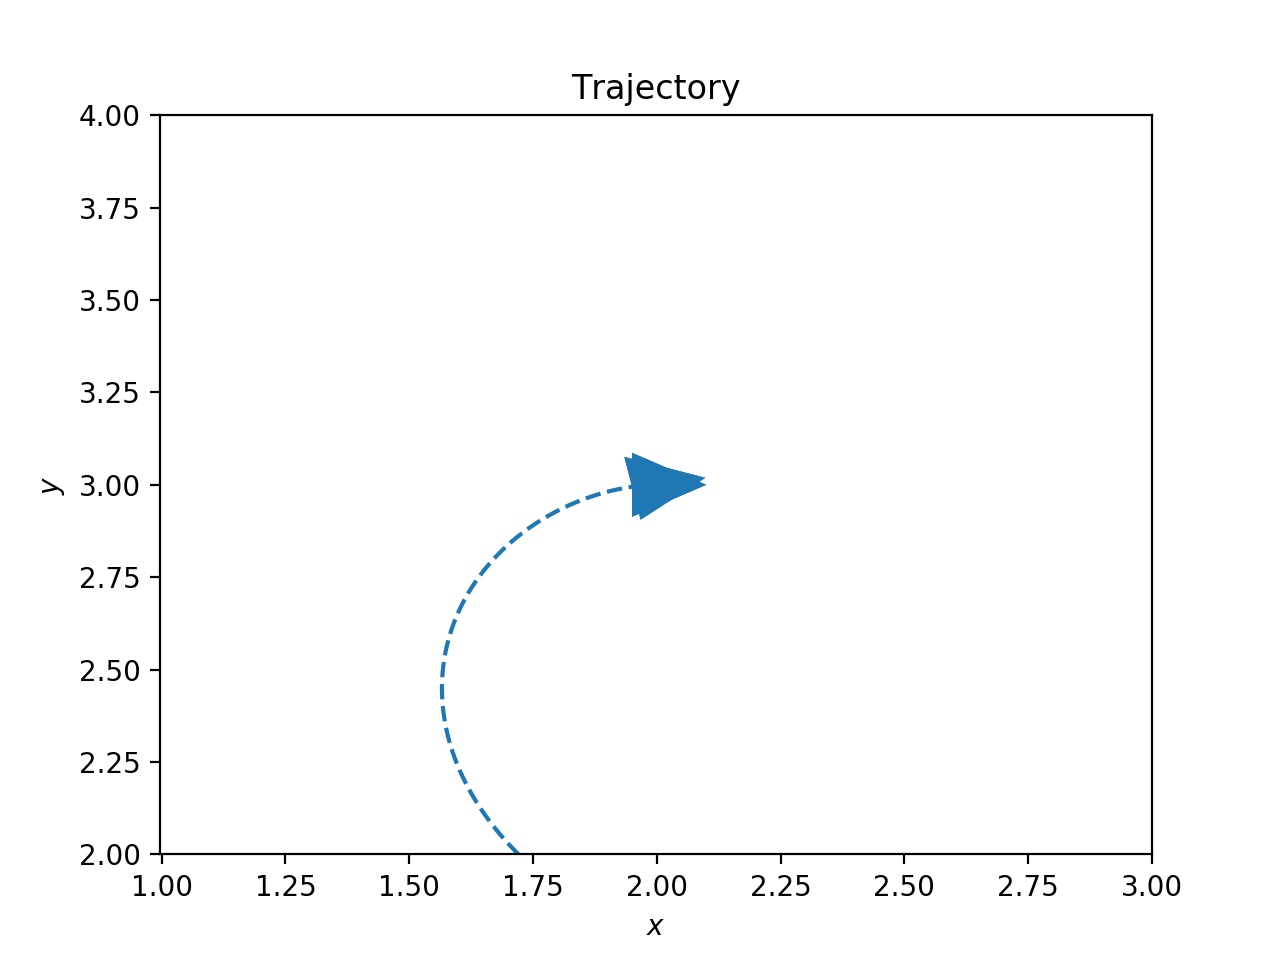

In [10]:
main()